For this chapter I will use functions from chapter 1 of the book that are implemented in different libraries, because I have already implemented them myself (see chapter1 directory) and functiom from the libraries are for sure more efficient.

### Task 1
Use the rate given by equation 2.1 with $r_0$ = 50 Hz and 
$$
D(\tau) = -cos\left(\frac{2\pi(\tau - 20 \ ms)}{140 \ ms}\right)exp\left(-\frac{\tau}{60 \ ms}\right) Hz/ms
$$
<br>

to predict the response of a neuron of the electrosensory lateral-line lobe to a stimulus. The above equation is an approximation for the linear kernel obtained from the spike-triggered average shown in figure 1.9. Use an approximate Gaussian white-noise stimulus to constructed by choosing a stimulus value every 10 ms ($\Delta t$ = 10 ms) from a Gaussian distribution with zero mean and variance $\sigma_{s}^2 / \Delta t$ with $\sigma_{s}^2 = 10$. Compute the firing rate over a 10 s period. From the results, compute the firing rate-stimulus correlation $Q_{rs}(\tau)$.  Using equation 2.6, compare $Q_{rs}(-\tau)/\sigma_s^{2}$ with the kernel $D(\tau)$ fiven above.

We will do everything with respect to seconds, therefore, we have to convert $Hz/ms$ to $Hz/s = Hz/(ms \cdot 10^{-3})$ => $D(\tau) := 1000 \cdot D(\tau)$. <br>
Also all constants in the equation with ms (milliseconds) will be converted to s (seconds).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [10.0, 6.0]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 0.8

Define Wiener kernel and white noise stimulus

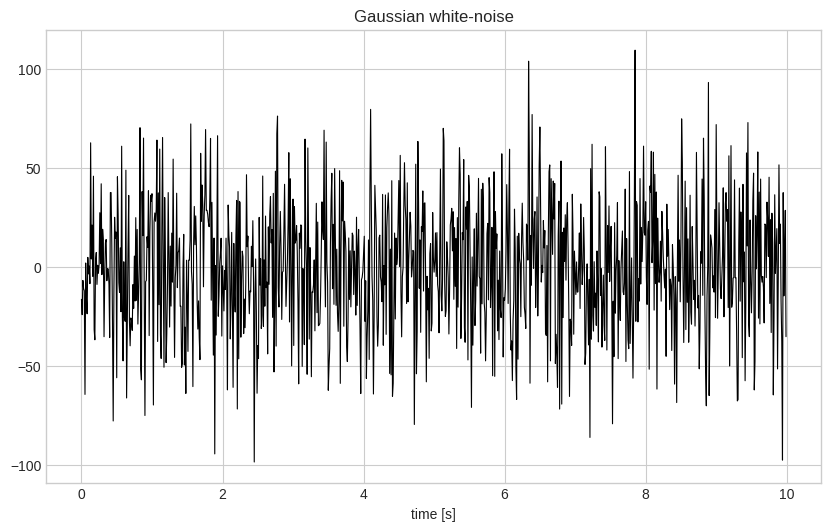

In [11]:
def D(τ):
    return -1000*np.cos(2*np.pi*(τ - 0.02)/0.14)*np.exp(-τ/0.06)
    
time = 10 
Δt = 0.01
σ = np.sqrt(10)
var = σ**2 / Δt

time_vec = np.arange(0, 10, Δt)
wn_stim = np.random.normal(loc=0, scale=np.sqrt(var), size=int(time/Δt))
plt.plot(time_vec, wn_stim, 'k');
plt.xlabel('time [s]')
plt.title('Gaussian white-noise');

Now we calculate the firing rate given the equation:
$$
r(t) = 50 + \int_0^{300 \ ms}{d\tau D(\tau)s(t - \tau)}
$$

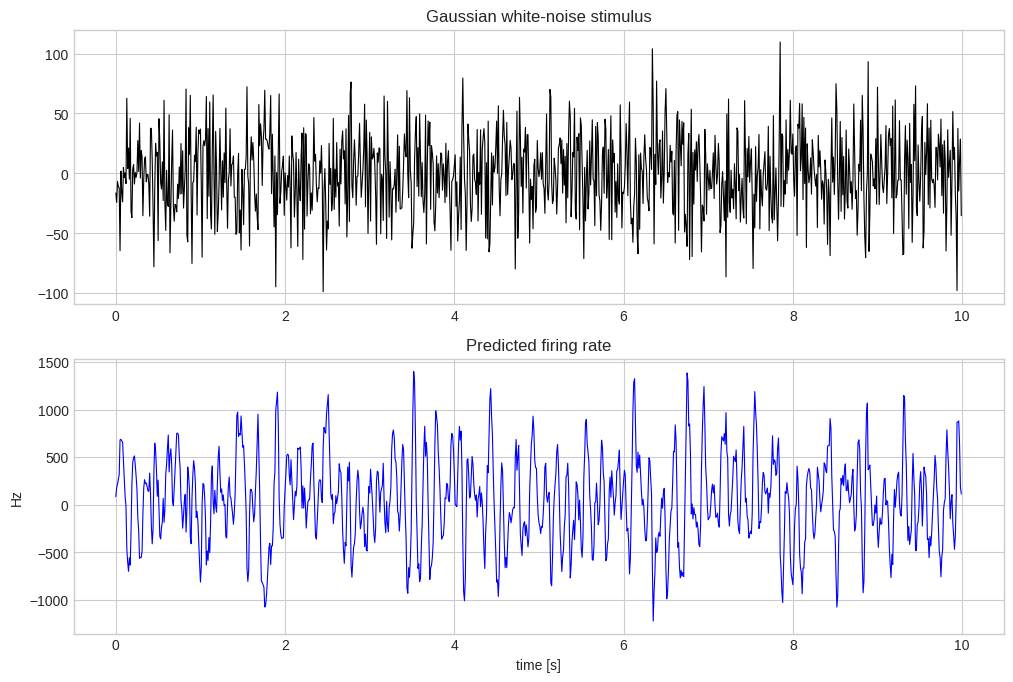

In [12]:
τ = np.arange(0, 0.6, Δt)
K = D(τ)

r = 50 + np.convolve(K, np.concatenate((wn_stim[-K.size+1:], wn_stim)), mode='valid') * Δt
#r = r[K.size+:]
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(time_vec, wn_stim, 'k')
axs[0].set_title('Gaussian white-noise stimulus');
axs[1].plot(time_vec, r, 'b')
axs[1].set(xlabel='time [s]', ylabel='Hz');
axs[1].set_title('Predicted firing rate');

Calculate response-stimulus crosscorrelation:
    $$
    Q_{rs}(\tau) = \frac{1}{10 \ s} \int_{0}^{10 \ s}{dt \ r(t) s(t + \tau)}
    $$
<br>
I interchange terms in the code below for the np.correlate function, becuase in the docs one can see:
$$
C_{av}[k] = \sum_{0}^n{a[n+k] \cdot v[n]}
$$

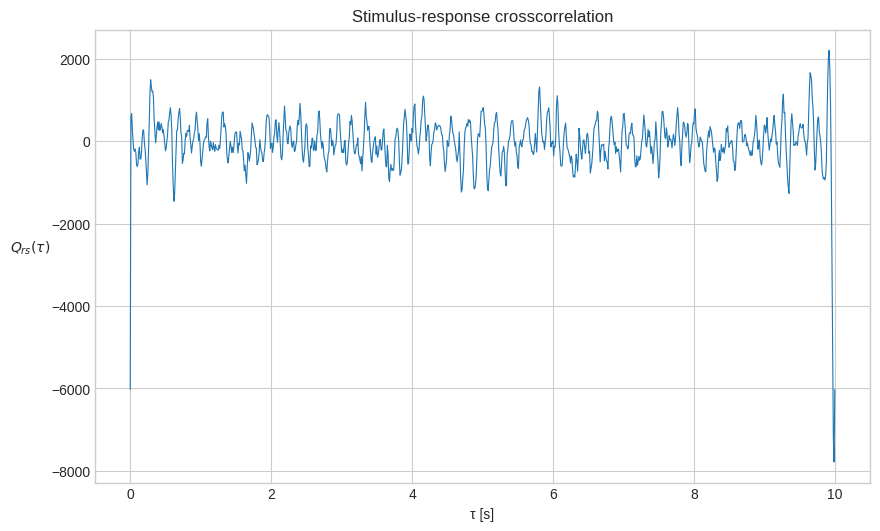

In [13]:
Q_rs = np.correlate(np.concatenate((wn_stim, wn_stim)), r, mode='valid') # concatenation for making signal cyclic
Q_rs = Q_rs / r.size
plt.plot(np.linspace(0, time, Q_rs.size), Q_rs);
plt.xlabel('τ [s]');
plt.ylabel('$Q_{rs}(τ)$', labelpad=15).set_rotation(0);
plt.title('Stimulus-response crosscorrelation');

Compare kernels from two different formulas:

$$
Q_{rs}(-\tau) = \frac{1}{10 \ s} \int_0^{10 \ s}{dt \ r(t) s(t - \tau)}  = \frac{1}{10 \ s} \int_0^{10 \ s}{dt \ s(t) r(t + \tau)}
$$

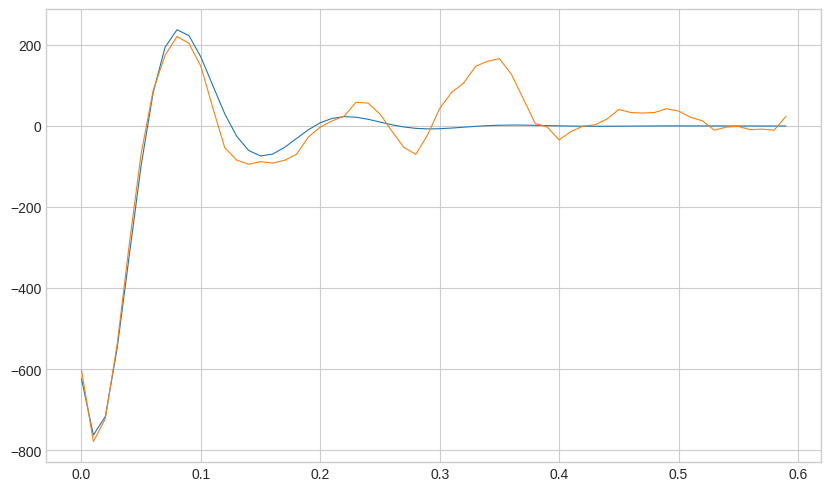

In [15]:
Q_rs = np.correlate(np.concatenate((r, r)), wn_stim, mode='valid') / r.size
D1 = D(τ)
D2 = Q_rs[0:τ.size] / σ**2
plt.plot(τ, D1)
plt.plot(τ, D2)